In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing as pre
import string
from scipy.special import expit as sigmoid
from __future__ import division

In [12]:
def print_letter(arr, label):
    label = label-1
    mnist_image = ""
    for x in range(28 * 28 - 1):
        if x % 28 == 0:
            mnist_image += '\n'
        if (arr[x] == 0):
            mnist_image += ' '
        else:
            mnist_image += '*'
    print(mnist_image)
    print list(string.ascii_lowercase)[label], label

In [13]:
data = sio.loadmat('hw6_data_dist/letters_data.mat')
train_x = data['train_x']
train_y = np.ndarray.flatten(data['train_y'])

order = np.arange(train_x.shape[0])
np.random.shuffle(order)
shuffled_data = np.take(train_x, order, 0)
shuffled_labels = np.take(train_y, order, 0)

VALID_SPLIT = int(0.8 * train_x.shape[0])
train_data, valid_data = shuffled_data[:VALID_SPLIT], shuffled_data[VALID_SPLIT:]
train_labels, valid_labels = shuffled_labels[:VALID_SPLIT], shuffled_labels[VALID_SPLIT:]

test_data = data['test_x']

"""We center all the data by the train_data mean since we're training on train_data"""
mean = np.mean(train_data, axis=0)
train_data = (train_data - mean) / 255
train_data = np.append(train_data, np.ones((len(train_data), 1), dtype='int'), axis=1)

valid_data = (valid_data - mean) / 255
valid_data = np.append(valid_data, np.ones((len(valid_data), 1), dtype='int'), axis=1)

all_data = (shuffled_data - mean) / 255
all_data = np.append(all_data, np.ones((len(all_data), 1), dtype='int'), axis=1)

test_data = (test_data - mean) / 255
test_data = np.append(test_data, np.ones((len(test_data), 1), dtype='int'), axis=1)

In [14]:
d, b, k = 784, 200, 26

In [15]:
def kaggle_write(nn, images):
    predictions = nn.predict(images)
    f = open('kaggle.csv', 'w')
    f.write("Id,Category\n")
    i = 1
    for p in predictions:
        f.write("{},{}\n".format(i, int(p)))
        i += 1
    f.close()

In [30]:
class NeuralNet:
    """ Initializes NeuralNet
    :param learning_rate: learning rate for gradient descent
    :param decay: scale learning_rate by decay at the end of each epoch
    :param epochs: max number of epochs
    """
    def __init__(self, learning_rate=0.01, decay=0.9, epochs=1):            
        self.learning_rate = learning_rate
        self.decay = decay
        self.epochs = epochs
        
        self.V = np.random.rand(b, d) - 0.5
        self.W = np.random.rand(k, b) - 0.5
        self.V = np.append(self.V, np.ones((b, 1), dtype='int'), axis=1)
        self.W = np.append(self.W, np.ones((k, 1), dtype='int'), axis=1)
        
        self.iterations = []
        self.losses = []
        
    def train(self, images, labels, granularity=1000):
        counter = 0
        for c in range(self.epochs):
            print c
            for x, y in zip(images, labels):
                z, h = self.forward_pass(x)
                y = self.hot_encode(y)
                gradwL, gradvL = self.backward_pass(x, h, z, y)
                self.V = self.V - self.learning_rate * gradvL
                self.W = self.W - self.learning_rate * gradwL
                if counter % granularity == 0:
                    loss = self.cross_entropy_loss(z, y)
                    if not np.isnan(loss) and not np.isinf(loss):
                        self.iterations.append(counter)
                        self.losses.append(loss)
                counter += 1
            self.learning_rate *= self.decay
                    
            order = np.arange(images.shape[0])
            np.random.shuffle(order)
            images = np.take(images, order, 0)
            labels = np.take(labels, order, 0)
    
    def predict(self, images):
        predictions = []
        for x in images:
            z, _ = self.forward_pass(x)
            predictions.append(np.argmax(z) + 1)
        return predictions
    
    def validate(self, images, labels):
        if len(labels) != len(images):
            print 'Mismatch of labels ({}) and images ({})'.format(labels.shape, images.shape)
        i, correct, correctp, incorrectp = 0, 0, [], []
        for pred, label in zip(self.predict(images), labels):
            if pred == label:
                correct += 1
                correctp.append([i, pred])
            else:
                incorrectp.append([i, pred])
            i += 1
        return correct, correctp, incorrectp
            
    def hot_encode(self, y):
        label = np.zeros((k, 1), dtype=int)
        label[y-1] = 1
        return label
    
    def cross_entropy_loss(self, z, y):
        loss, lnz, inv_lnz = 0, np.log2(z), np.log2(1 - z)
        for i in range(k):
            loss += y[i] * lnz[i] + (1 - y[i]) * inv_lnz[i]
        return -loss[0]
    
    def forward_pass(self, x):
        Vx = self.V.dot(x)
        h = np.append(np.tanh(Vx), [1], axis=0)
        z = sigmoid(self.W.dot(h))
        return z, h
    
    def backward_pass(self, x, h, z, y):
        x = np.reshape(x, (x.shape[0], 1))
        h = np.reshape(h, (h.shape[0], 1))
        z = np.reshape(z, (z.shape[0], 1))
        
        gradhL = self.W.T.dot(z-y)
        gradvh = 1 - np.square(h)
        gradvL = np.outer(gradhL * gradvh, x)
        gradvL = np.delete(gradvL, -1, axis=0)
        gradwL = np.outer(z-y, h)
        return gradwL, gradvL

In [31]:
nn2 = NeuralNet(epochs=5)
nn2.train(train_data, train_labels)
train_correct, traincp, trainip = nn2.validate(train_data, train_labels)
valid_correct, validcp, validip = nn2.validate(valid_data, valid_labels)

print "Training Accuracy: {}%".format(100 * train_correct / len(train_labels))
print "Validation Accuracy: {}%".format(100 * valid_correct / len(valid_labels))

0
1
2
3
4
Training Accuracy: 91.4493189103%
Validation Accuracy: 87.5681089744%


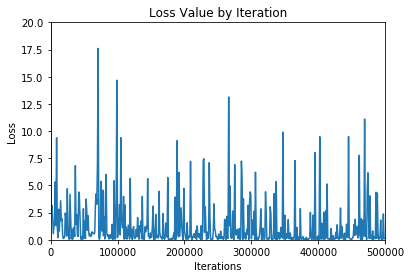

In [32]:
plt.xlim([0, 5*10e4])
plt.ylim([0, 20])
# plt.xlim(xmin=1) 
plt.plot(nn2.iterations, nn2.losses)
plt.title('Loss Value by Iteration')
ax = plt.gca()

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('loss.png', bbox_inches='tight')
plt.show()

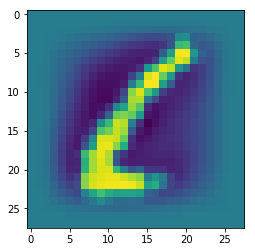

In [34]:
import string
alphabet = string.ascii_lowercase
counter = 1
while counter <= 5:
    i, pred = validcp[counter]
    img = np.reshape(np.delete(valid_data[i], -1), (28, 28))
    plt.imshow(img)
    plt.savefig('valid_correct{}_{}.png'.format(counter, alphabet[valid_labels[i]-1]), bbox_inches='tight')
    counter += 1

counter = 1
while counter <= 5:
    i, pred = validip[counter]
    img = np.reshape(np.delete(valid_data[i], -1), (28, 28))
    plt.imshow(img)
    plt.savefig('valid_incorrect{}_{}.png'.format(counter, alphabet[valid_labels[i]-1]), bbox_inches='tight')
    counter += 1

In [50]:
nna = NeuralNet(epochs=5)
nna.train(all_data, shuffled_labels)
tincorrect, tpredictions = nna.validate(all_data, shuffled_labels)

0
1
2
3
4
0.915841346154


In [58]:
kaggle_write(nna, test_data)

In [41]:
nn = NeuralNet(0.01, 0.9, 1)
nn.train(train_data, train_labels)

# small_data, small_labels = train_data[:100], train_labels[:100]
# nn.train(small_data, small_labels)
# correct, predictions = nn.validate(small_data, small_labels)
# for pred, label in zip(predictions, small_labels):
#     print pred, label, pred == label

0
